In [17]:
import numpy as np
import pandas as pd
import glob
import os
import datetime
import time
import math
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize = (8, 6))
matplotlib.rc('font', size = 22)


base_path = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/'

In [18]:
def return_unique_active_regions(DICT):
    
    print('getting the list of active regions for the validation files ...')
    ACTIVE = np.array([], dtype=np.int8)
    FILES = DICT.get(str(0))
    
    for F in FILES:
        ACTIVE_REGION = get_active_region(F)
        ACTIVE = np.append(ACTIVE, ACTIVE_REGION)
    uniqueActive = np.unique(ACTIVE)
    
    return uniqueActive

def get_flag(filePath):
    
    NAME = os.path.split(filePath)[-1]
    FLAG = NAME[-5]
    return int(FLAG)


def sort_active_region_files_wrt_time(CROSS_VALIDATION_FILE, uniqueActive):
    
    
    allSortedPaths = {}
    
    for i in range(len(uniqueActive)):

        PATHS = glob.glob("../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*.dat" %uniqueActive[i])
        
        TIME_ARR = []
        for j in range(len(PATHS)):

            FILE_NAME = os.path.split(PATHS[j])[-1]
            start = FILE_NAME.index('_')
            end = FILE_NAME.index('_', start+1)
            TIMESTAMP = FILE_NAME[start+1:end]
            TIME = datetime.datetime.strptime(TIMESTAMP,'%Y%m%dT%H%M')

            TIME_ARR.append(TIME)
        TIME_ARR.sort()
        

        SORTED_PATHS = [None]*len(TIME_ARR)

        for k in range(len(TIME_ARR)):
            FILE_NAME = os.path.split(PATHS[k])[-1]
            start = FILE_NAME.index('_')
            end = FILE_NAME.index('_', start+1)
            TIMESTAMP = FILE_NAME[start+1:end]
            TIME = datetime.datetime.strptime(TIMESTAMP,'%Y%m%dT%H%M')
            idx = TIME_ARR.index(TIME)
            SORTED_PATHS[idx] = PATHS[k]

        allSortedPaths[uniqueActive[i]] = SORTED_PATHS
        
    return allSortedPaths

def get_active_region(FILE):
    
    FILE_NAME = get_filename(FILE)
    start = FILE_NAME.index('_')
    ACTIVE_REGION = FILE_NAME[0:start]
    
    return ACTIVE_REGION

def get_filename(FILE):
    
    return os.path.split(FILE)[-1]


def rescaled_path_to_original_path(PATH):

    FILE_NAME = get_filename(PATH)
    ACTIVE_REGION = get_active_region(PATH)
    FLAG = get_flag(PATH)
        
    if (FLAG == 1):
        TYPE = 'flaring'
    else:
        TYPE = 'nonflaring'
        
    FILE_STRING = "../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/%s/%s/%s" %(TYPE, ACTIVE_REGION, FILE_NAME)
    
    return FILE_STRING


def select_files_of_specified_machine_prediction(crossValidationFile):
    data = {}
    for i in range(10):
        data[str(i)] = np.array([])
    
    validation = convert_to_dictionary(crossValidationFile)
    
    testData = validation.get(str(0))
    
    for i in range(len(testData)):
        xData = np.load(testData[i])
        xData = xData.reshape(1, 256, 256, 1)
        yData = model.predict(xData)
        
        for m in range(10):
            if (np.logical_and(yData > m*0.0, yData <= (m*0.1 + 0.1))):
                data[str(m)] = np.append(data[str(m)], testData[i])

    return data


def hour_rounder(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +datetime.timedelta(hours=t.minute//30))


def sorted_active_region_files(activeRegions):
    print('getting the sorted AR dates ...')
    allSortedPaths = sort_active_region_files_wrt_time(validation, activeRegions)
    dates = {}
    for activeRegion in activeRegions:
        dates[activeRegion] = []
        for k in range(len(allSortedPaths[activeRegion])):
            path = allSortedPaths[activeRegion][k]
            FILE_NAME = os.path.split(path)[-1]
            start = FILE_NAME.index('_')
            end = FILE_NAME.index('_', start+1)
            TIMESTAMP = FILE_NAME[start+1:end]
            TIME = datetime.datetime.strptime(TIMESTAMP,'%Y%m%dT%H%M')
            dates[activeRegion].append(TIME)
    return dates


def flareReader(dataPath, fname):
    with open(dataPath + '%s.txt' %fname) as fl:
        txtData = fl.readlines()
    txtData = [x.strip() for x in txtData]
    data = {}
    for entry in txtData:
        splits = entry.split('\t')
        arrNum = int(splits[0])
        data[arrNum] = []
        for item in splits[1:]:
            date = datetime.datetime.strptime(item.split(',')[0], '%Y-%m-%dT%H:%M:%S')
            data[arrNum].append(date)
    return data


def rashaValidationFiles():
    """
    Prepare the validation file in dictionary format
    """
    tempValidationRegions = ['1209', '1321', '1500', '1638', '1806', '1807', '1907', '1930',
           '1993', '1999', '2372', '2491', '2519', '2546', '2635', '2636',
           '2673', '2716', '2809', '3311', '3344', '3520', '3580', '3730',
           '384', '3877', '3894', '392', '393', '3941', '3999', '4344',
           '4396', '4817', '4941', '5127', '5186', '5541', '5692', '5738',
           '5745', '637', '750', '8', '833', '899', '902', '940', '1038', '1046', '107', '1089', '1126', '1133', '116', '1168',
           '1171', '1183', '1271', '1345', '1353', '1389', '1410', '145',
           '146', '1471', '1483', '1492', '1527', '1549', '1557', '1558',
           '1574', '1611', '1613', '1658', '1669', '1672', '1697', '1701',
           '1744', '175', '1756', '1845', '185', '1877', '1893', '190',
           '1949', '1959', '1962', '198', '2026', '2037', '2110', '2117',
           '2121', '2123', '2131', '2143', '2166', '2173', '2178', '2203',
           '2270', '2358', '2366', '2400', '2420', '2502', '2522', '2533',
           '2543', '2560', '2598', '2599', '2605', '2619', '2663', '2711',
           '2735', '2825', '2861', '2875', '2922', '2945', '2954', '2955',
           '2999', '3028', '3103', '318', '3205', '3246', '3252', '3267',
           '327', '3286', '3288', '3309', '3323', '3326', '3415', '3420',
           '3481', '3490', '3513', '355', '3604', '3635', '364', '3648',
           '3700', '3703', '3719', '3741', '3785', '3821', '3874', '3942',
           '3965', '3974', '4011', '403', '4065', '4092', '4093', '414',
           '4228', '4284', '4288', '43', '4315', '4321', '4337', '4397',
           '4424', '444', '4454', '4466', '4477', '4505', '4523', '4541',
           '4549', '4559', '46', '4610', '4623', '4655', '4661', '4678',
           '4718', '4726', '4792', '4800', '4900', '4942', '4943', '4969',
           '4991', '4995', '5002', '5004', '5022', '5051', '5054', '51',
           '5113', '5163', '5208', '5275', '5293', '5355', '5375', '538',
           '5387', '5413', '5422', '5521', '5543', '5544', '5550', '5577',
           '5618', '5678', '5710', '5718', '5750', '576', '5772', '580',
           '5820', '5831', '5856', '5865', '5880', '5916', '618', '625',
           '640', '652', '662', '674', '705', '712', '725', '740', '794',
           '824', '853', '854', '86', '867', '900', '913', '918', '925',
           '950', '986']
    

    validation = []

    print('creating the validation files....')
    for validationRegion in tempValidationRegions:
        paths = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*.dat' %validationRegion
        
        if (paths == []):
            continue
        filePaths = glob.glob(paths)
        validation.extend(filePaths)


    np.random.shuffle(validation)

    VALIDATION = {}

    VALIDATION[str(0)] = validation
    
    return VALIDATION


def allFiles():
    files = glob.glob('../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/*.dat')
    FILES = {}
    FILES[str(0)] = files
    
    return FILES


def trainingAndValidationFiles():
    RASHA_FLARING_TRAIN_REGIONS = ['1028', '1041', '1066', '115', '1256', '1350', '1449', '1461',
       '1464', '1582', '1603', '1621', '1722', '1724', '1750', '1834',
       '1879', '1946', '1996', '2040', '211', '2137', '2186', '2191',
       '2193', '2220', '2227', '2362', '245', '2693', '2739', '2748',
       '2760', '2790', '2878', '2887', '2920', '3048', '3056', '3258',
       '3263', '3291', '3295', '3321', '3341', '3364', '3366', '3376',
       '3437', '345', '3497', '3535', '3563', '3587', '362', '3686',
       '3688', '3721', '3740', '3766', '377', '3779', '3784', '3793',
       '3804', '3813', '3836', '3856', '3879', '394', '4000', '401',
       '407', '4071', '4097', '4138', '415', '4186', '4197', '4231',
       '4294', '437', '4639', '4698', '4781', '4874', '49', '4920', '495',
       '4955', '5011', '5026', '5107', '514', '5144', '5233', '5298',
       '54', '5415', '5446', '5447', '5526', '5637', '5653', '5673',
       '5885', '667', '746', '753', '814', '856', '878', '892']

    RASHA_NONFLARING_TRAIN_REGIONS = ['1', '1001', '1019', '1021', '1026', '104', '1062', '1075', '1079',
       '1080', '1090', '1092', '1093', '1113', '1119', '1120', '1124',
       '114', '1149', '1186', '12', '1210', '1221', '1237', '1249',
       '1275', '1278', '128', '1300', '1303', '1309', '1312', '1313',
       '1318', '1338', '1339', '1342', '1348', '135', '1367', '1390',
       '1391', '1396', '1399', '1405', '1422', '1424', '1425', '1447',
       '1455', '1457', '1465', '1484', '1488', '1514', '1520', '1528',
       '156', '1573', '1578', '1596', '1628', '1632', '1634', '1642',
       '1644', '1653', '1662', '1677', '1688', '1705', '1711', '1715',
       '1727', '1795', '1819', '1832', '1863', '1866', '187', '1873',
       '1886', '1892', '1903', '1931', '1951', '1970', '1979', '1990',
       '2007', '2011', '2017', '2021', '2028', '2039', '2044', '2047',
       '2059', '2061', '2069', '2098', '2106', '2109', '2112', '2130',
       '218', '2181', '220', '224', '2240', '2245', '226', '2262', '2291',
       '2306', '2314', '2337', '2338', '2341', '2342', '2344', '2352',
       '2353', '2360', '2380', '2387', '241', '2411', '2414', '2433',
       '2450', '2460', '2469', '2489', '2492', '2501', '2504', '2511',
       '252', '2520', '2541', '2557', '256', '2571', '2573', '2581',
       '2583', '2585', '2587', '259', '2597', '26', '2625', '2634',
       '2651', '2661', '2672', '2677', '2685', '2691', '2696', '2718',
       '2727', '2732', '2733', '2737', '274', '2749', '2750', '2758',
       '2779', '279', '2822', '2832', '284', '2852', '2904', '2912',
       '2952', '2964', '2966', '2968', '297', '2981', '2984', '3012',
       '3019', '3022', '3031', '3032', '3049', '3066', '3068', '3082',
       '3097', '3098', '3114', '3115', '3119', '3122', '3129', '3149',
       '3154', '3194', '3195', '3199', '3217', '3220', '323', '3240',
       '3244', '3247', '3248', '325', '3259', '3273', '3293', '3330',
       '3336', '3368', '3371', '3400', '3432', '3448', '3457', '3461',
       '3473', '3474', '3483', '3515', '3542', '3560', '3586', '3601',
       '3608', '3620', '3631', '3647', '3668', '367', '3711', '3753',
       '38', '3823', '3824', '3826', '3843', '3845', '3848', '3901',
       '3907', '3912', '3921', '3926', '3957', '3978', '3982', '3985',
       '3996', '4025', '4038', '4040', '4042', '4073', '4075', '4076',
       '4088', '4108', '4111', '4123', '4131', '4133', '4156', '4166',
       '4190', '4201', '4205', '421', '4218', '4252', '4256', '4265',
       '4272', '4287', '429', '4296', '4328', '4335', '4351', '4375',
       '4379', '438', '4383', '4390', '4398', '4399', '443', '4438',
       '4440', '4447', '4448', '4455', '4469', '4478', '4502', '451',
       '4530', '4536', '4539', '4543', '4551', '4552', '4556', '4566',
       '4574', '4576', '4579', '4580', '4591', '4603', '4616', '4640',
       '466', '4667', '4673', '4702', '4704', '4711', '4724', '4734',
       '475', '4751', '4760', '4761', '4764', '4767', '4783', '4799',
       '480', '4802', '4851', '4862', '4864', '4868', '4872', '4882',
       '4888', '4889', '4908', '4921', '4932', '4954', '4962', '4963',
       '4973', '4978', '5005', '5012', '5028', '5036', '5039', '504',
       '5073', '5075', '5103', '5111', '5112', '5118', '5135', '5140',
       '5151', '5152', '5183', '5198', '5212', '5229', '5230', '5246',
       '5249', '5265', '5284', '5315', '532', '5337', '5342', '5347',
       '5351', '5354', '5366', '5374', '5385', '540', '5456', '5462',
       '5467', '5472', '5484', '5490', '5492', '5500', '5518', '5534',
       '5535', '5537', '5545', '5549', '5559', '556', '5571', '5586',
       '5596', '5598', '5627', '5635', '5644', '5658', '5677', '57',
       '5724', '5739', '5758', '5783', '5789', '5807', '5808', '5811',
       '5818', '5823', '5848', '5852', '587', '5890', '5894', '5908',
       '5919', '5927', '598', '602', '605', '606', '610', '622', '639',
       '643', '650', '661', '681', '684', '685', '686', '695', '702',
       '71', '713', '714', '759', '764', '765', '798', '803', '805',
       '812', '843', '847', '850', '851', '869', '875', '903', '909',
       '92', '921', '926', '927', '932', '948', '956', '970', '971',
       '973', '975', '976', '982', '997']

    RASHA_FLARING_VALIDATION_REGIONS = ['1209', '1321', '1500', '1638', '1806', '1807', '1907', '1930',
       '1993', '1999', '2372', '2491', '2519', '2546', '2635', '2636',
       '2673', '2716', '2809', '3311', '3344', '3520', '3580', '3730',
       '384', '3877', '3894', '392', '393', '3941', '3999', '4344',
       '4396', '4817', '4941', '5127', '5186', '5541', '5692', '5738',
       '5745', '637', '750', '8', '833', '899', '902', '940']

    RASHA_NONFLARING_VALIDATION_REGIONS = ['1038', '1046', '107', '1089', '1126', '1133', '116', '1168',
       '1171', '1183', '1271', '1345', '1353', '1389', '1410', '145',
       '146', '1471', '1483', '1492', '1527', '1549', '1557', '1558',
       '1574', '1611', '1613', '1658', '1669', '1672', '1697', '1701',
       '1744', '175', '1756', '1845', '185', '1877', '1893', '190',
       '1949', '1959', '1962', '198', '2026', '2037', '2110', '2117',
       '2121', '2123', '2131', '2143', '2166', '2173', '2178', '2203',
       '2270', '2358', '2366', '2400', '2420', '2502', '2522', '2533',
       '2543', '2560', '2598', '2599', '2605', '2619', '2663', '2711',
       '2735', '2825', '2861', '2875', '2922', '2945', '2954', '2955',
       '2999', '3028', '3103', '318', '3205', '3246', '3252', '3267',
       '327', '3286', '3288', '3309', '3323', '3326', '3415', '3420',
       '3481', '3490', '3513', '355', '3604', '3635', '364', '3648',
       '3700', '3703', '3719', '3741', '3785', '3821', '3874', '3942',
       '3965', '3974', '4011', '403', '4065', '4092', '4093', '414',
       '4228', '4284', '4288', '43', '4315', '4321', '4337', '4397',
       '4424', '444', '4454', '4466', '4477', '4505', '4523', '4541',
       '4549', '4559', '46', '4610', '4623', '4655', '4661', '4678',
       '4718', '4726', '4792', '4800', '4900', '4942', '4943', '4969',
       '4991', '4995', '5002', '5004', '5022', '5051', '5054', '51',
       '5113', '5163', '5208', '5275', '5293', '5355', '5375', '538',
       '5387', '5413', '5422', '5521', '5543', '5544', '5550', '5577',
       '5618', '5678', '5710', '5718', '5750', '576', '5772', '580',
       '5820', '5831', '5856', '5865', '5880', '5916', '618', '625',
       '640', '652', '662', '674', '705', '712', '725', '740', '794',
       '824', '853', '854', '86', '867', '900', '913', '918', '925',
       '950', '986']
    
    allRegions = RASHA_FLARING_TRAIN_REGIONS + RASHA_NONFLARING_TRAIN_REGIONS + RASHA_FLARING_VALIDATION_REGIONS + RASHA_NONFLARING_VALIDATION_REGIONS
    
    files = []
    
    for rgn in allRegions:
        rgnstr = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*.dat' %(rgn)
        rgnfiles = glob.glob(rgnstr)
        files.extend(rgnfiles)
        
    FILES = {}
    FILES[str(0)] = files
    
    return FILES
    

In [19]:
"""

final data format ====>

allData = {
    4078: {1: 
        [datetime array (-72 -> 72 file paths)], 
           2: 
        [datetime array],
        ...number of flares}, 
    871: {1: 
        [datetime array], 
           2: 
        [datetime array],
        ...number of flares
    ...,
    ...,
}

"""

def getAlignedSamples(validationFile, tempActiveRegions, sortedARDates):
    
    dataPath = ""
    fname = "flareData"
    flareData = flareReader(dataPath, fname) 
    
    tw = 72 
    maxIndex = tw*2
    xMid = maxIndex / 2
    
    
    # store the rounded dates
    allRoundedDates = {}
    
    for k in sortedARDates.keys():
        tempDates = sortedARDates[k]
        allRoundedDates[k] = []
        for i in range(len(tempDates)):
            allRoundedDates[k].append(hour_rounder(tempDates[i]))
    
    
    # retain only those active regions which are present in the flareData file
    activeRegions = [activeRegion for activeRegion in tempActiveRegions if int(activeRegion) in flareData.keys()] 
    
    
    
    allData = {} #final data
    
    
    for activeRegion in activeRegions: 
        
        # rounded and sorted dates for the current activeRegion
        dates = allRoundedDates[activeRegion]
        
        #new
        originalDates = sortedARDates[activeRegion]
        
        
        maxLen = len(dates)
        
    
        # All flaring dates for the current activeRegion
        flareDates = flareData[int(activeRegion)]
        
        # Will contain only those flaring dates which are present in the dates array
        tempFlareDates = []
        
        
        for l in range(len(flareDates)):
            if (hour_rounder(flareDates[l]) in dates):
                tempFlareDates.append(hour_rounder(flareDates[l]))
        
        # if no flareDate is found for the current activeRegion dates, then exit the loop for the current activeRegion
        if (len(tempFlareDates) == 0):
            continue
        
        # will contain multiple key array pairs, each corresponding to each flaringDate for the currentActiveRegion. 
        # Each array contains the desired -72 -> 72 hours filepaths for the current activeRegion.
        
        allData[activeRegion] = {} 
        
        
        """
        Example for an activeRegion with two flaring dates
        
                            ------sorted datetime---->
        
        <-------------->|<---------------->|<------------->|<-------------->|
        |               |                  |               |
                    flare1                mid            flare2 
        |                                  |                                |
        dateIndex[0]                       dateIndex[1]                     dateIndex[2]
        
        <-----------dateRange[0]----------><-----------dateRange[1]-------->
        """
        
        dateIndex = [None]*(len(tempFlareDates) + 1)
        dateIndex[0] = 0
        dateIndex[-1] = maxLen
        
        if (len(tempFlareDates) > 1):
            for m in range(len(tempFlareDates) - 1):
                firstIndex = dates.index(tempFlareDates[m])
                secondIndex = dates.index(tempFlareDates[m+1])

                # mid index of the two flares
                midIndex = ( secondIndex + firstIndex ) // 2

                dateIndex[m+1] = midIndex
            
            
        dateRange = [None]*(len(dateIndex) - 1)
        originalDateRange = [None]*(len(dateIndex) - 1)
        
        
        for n in range(len(dateRange)):
            dateRange[n] = dates[dateIndex[n]:(dateIndex[n+1] + 1)]
            originalDateRange[n] = originalDates[dateIndex[n]:(dateIndex[n+1] + 1)]
        
        
        # Now iterate over all the date ranges for the current active region
        
        for o in range(len(dateRange)):
            
            # allData[key for the current active region][key for the daterange] = array of zeros of length 145
            
            allData[activeRegion][o] = [0]*(2*tw + 1)
            
            # the o-th daterange
            tempDates = dateRange[o]
            
            
            # check that dateRange[o] contains atleats 72 files.
            
            if (len(tempDates) < 72):
                continue
            
            originalTempDates = originalDateRange[o]
            #print(tempDates)
            # the index of the o-th flaring date in the o-th daterange
            flareIndex = tempDates.index(tempFlareDates[o])
            
            
            # dateStartIndex and dateEndIndex represents the start and end positions of the dates, which will be stored in the array of zeros 
            # xStartIndex and xEndIndex corresponds to the start and end positions for the array of zeros
            
            
            if (xMid > flareIndex):
                dateStartIndex = 0
                xStartIndex = xMid - flareIndex
            else:
                xStartIndex = 0
                dateStartIndex = flareIndex - xMid

            if (xMid > (len(tempDates) - flareIndex)):
                dateEndIndex = len(tempDates) - 1
                xEndIndex = xMid + (len(tempDates) - flareIndex)
            else:
                xEndIndex = maxIndex
                dateEndIndex = flareIndex + xMid
                
            
            
            # convert the datetime objects to file strings
            dateRangeFiles = []
            
            for dt in originalTempDates:
                dtime = dt.strftime('%Y%m%dT%H%M')
                fileString = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_%s_1.dat' %(activeRegion, dtime)
                dateRangeFiles.append(fileString)
                
            
            # store the file strings    
            allData[activeRegion][o][xMid] = dateRangeFiles[flareIndex] # flare path
            allData[activeRegion][o][xStartIndex:xMid] = dateRangeFiles[dateStartIndex:flareIndex] # -72 hrs paths
            allData[activeRegion][o][xMid+1:xEndIndex+1] = dateRangeFiles[flareIndex+1:dateEndIndex+1] # +72 hrs paths

    return allData

In [20]:
validation = rashaValidationFiles()
#validation = trainingAndValidationFiles()
activeRegions = return_unique_active_regions(validation)
sortedARDates = sorted_active_region_files(activeRegions)

creating the validation files....
getting the list of active regions for the validation files ...
getting the sorted AR dates ...


In [21]:
alignedTimeData = getAlignedSamples(validation, activeRegions, sortedARDates)

#### `Samples histogram plot =====>`

[18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 28, 28, 28, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 33, 34, 34, 35, 35, 35, 36, 36, 37, 37, 38, 39, 39, 40, 41, 42, 43, 44, 44, 44, 43, 42, 40, 40, 37, 37, 36, 36, 36, 36, 35, 35, 35, 34, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 27, 27, 27, 27, 27, 27, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 22, 22, 22, 22, 22, 22]


Text(0,0.5,'Number of files')

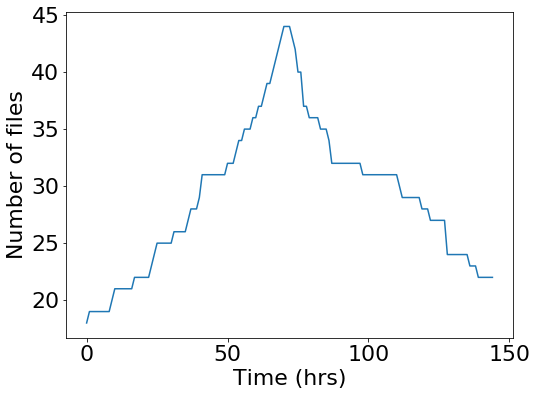

In [22]:
def alignedSamplesHist(tw, alignedSamplesDict):
    
    histDict = [0]*(2*tw + 1)
    for k in alignedSamplesDict.keys():
        filesDict = alignedSamplesDict[k]
        for ky in filesDict.keys():
            files = filesDict[ky]
            
            nonZeroFiles = [f for f in files if f != 0]
            
            tot = len(nonZeroFiles)
            for i, _ in enumerate(files):
                if (_ != 0):
                    break
            for j in range(i, (i+tot)):
                histDict[j]+=1
    return histDict


histDict = alignedSamplesHist(72, alignedTimeData)
print(histDict)
_, ax = plt.subplots()
ax.plot(histDict)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Number of files')

#### `Get the machine prediction dictionary =====>`

In [23]:
import os
import tensorflow as tf
import keras
from keras.models import load_model
from sklearn.metrics import confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3))
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

model = load_model('inception_with_generator/model_3.h5')


predDict = {}
for ky in alignedTimeData.keys():
    predDict[ky] = {}
    for itm in alignedTimeData[ky].keys():
        predDict[ky][itm] = [0]*145
        for idx, filePath in enumerate(alignedTimeData[ky][itm]):
            if (filePath != 0):
                img = np.load(filePath)
                img = img.reshape(1, 256, 256, 1)
                pred = model.predict(img)
                predDict[ky][itm][idx] = float(pred[0])

#### `Get the tp and fn timestamp dictionary =====>`

In [24]:
tpAlignedDict = {}
fnAlignedDict = {}

for ky in alignedTimeData.keys():
    tpAlignedDict[ky] = {}
    fnAlignedDict[ky] = {}
    for k in alignedTimeData[ky].keys():
        tpAlignedDict[ky][k] = [0]*145
        fnAlignedDict[ky][k] = [0]*145
        for idx, item in enumerate(alignedTimeData[ky][k]):
            if (predDict[ky][k][idx] > 0.5):
                file_name = os.path.split(alignedTimeData[ky][k][idx])[-1]
                start = file_name.index('_')
                end = file_name.index('_', start+1)
                timestamp = file_name[start+1:end]
                tpAlignedDict[ky][k][idx] = timestamp
            elif ( predDict[ky][k][idx] != 0 and predDict[ky][k][idx] <= 0.5):
                file_name = os.path.split(alignedTimeData[ky][k][idx])[-1]
                start = file_name.index('_')
                end = file_name.index('_', start+1)
                timestamp = file_name[start+1:end]
                fnAlignedDict[ky][k][idx] = timestamp
                
np.save("tp_dict_new.npy", tpAlignedDict)
np.save("fn_dict_new.npy", fnAlignedDict)

#### `Get the machine prediction dictionary (compact form: no zeros) =====> `

In [25]:
allPredDict = {}

for i in range(145):
    allPredDict[i] = []
for ky in predDict.keys():
    for itm in predDict[ky].keys():
        for idx, pred in enumerate(predDict[ky][itm]):
            if (pred != 0):
                allPredDict[idx].append(pred)
                
avgPredDict = []
stdPredDict = []

for ky in allPredDict.keys():
    avgPredDict.append(np.mean(allPredDict[ky]))
    stdPredDict.append(np.std(allPredDict[ky])/ np.sqrt(len(allPredDict[ky])) )
    
np.save('avgPredDict.npy', avgPredDict)
np.save('stdPredDict.npy', stdPredDict)

#### `Get the recall array =====>`

In [26]:
allRecallDict = {}

for i in range(145):
    allRecallDict[i] = np.array([])
for ky in predDict.keys():
    for itm in predDict[ky].keys():
        for idx, pred in enumerate(predDict[ky][itm]):
            if (pred != 0):
                allRecallDict[idx] = np.append(allRecallDict[idx], pred)


recallArr = []
recallStd = []

for ky in allRecallDict.keys():
    recallArr.append( len(allRecallDict[ky][allRecallDict[ky] > 0.5])/np.float(len(allRecallDict[ky])) )
    recallStd.append(np.std(allRecallDict[ky])/( np.sqrt(len(allRecallDict[ky])) ))
    
np.save('recallArr.npy', recallArr)
np.save('recallStd.npy', recallStd)

#### `Recall wrt time plots =====>`

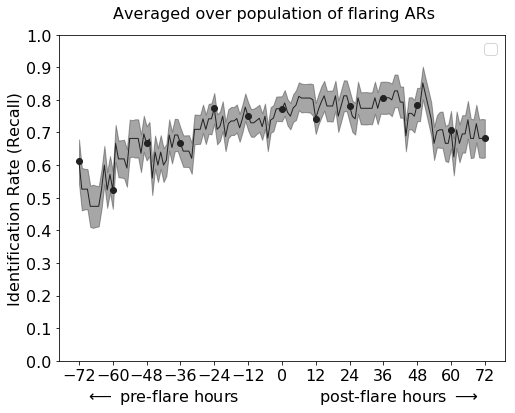

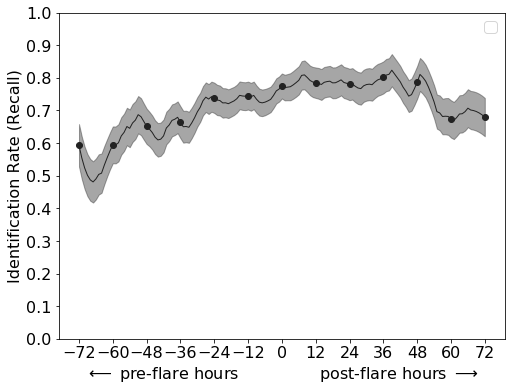

In [27]:
from scipy.signal import savgol_filter
matplotlib.rc('figure', figsize = (8, 6))
matplotlib.rc('font', size = 16)

x_data = np.linspace(-72, 72, num=145, endpoint=True)
y_data = np.array(recallArr)
y_data_sm = np.array([])

for i in range(len(y_data)//2):
    y_data_sm = np.append(y_data_sm, np.mean(y_data[i:i+2]))

y_hat = savgol_filter(y_data, 11, 2)
    
std = np.array(recallStd)
std_hat = savgol_filter(std, 11, 2)


_, ax = plt.subplots()
#ax.plot(x_data, y_data, lw = 1, color = '#539caf', alpha = 1, label = 'Recall(Y)')
markers_on = 12
ax.plot(x_data, y_data, '-o', lw = 1, color = '#222222', alpha = 1, markevery=markers_on)
ax.fill_between(x_data, y_data + std, y_data - std, color = '#222222', alpha = 0.4)
ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0,1.1,0.1))
ax.set_xticks(np.arange(-72, 84, 12))
ax.set_xlabel('$\longleftarrow$ pre-flare hours' + '\t \t' + 'post-flare hours $\longrightarrow$')
ax.set_ylabel('Identification Rate (Recall)')
ax.text(-60,1.05, 'Averaged over population of flaring ARs')

ax.legend(loc = 'best')

_, ax = plt.subplots()
#ax.plot(x_data, y_data, lw = 1, color = '#539caf', alpha = 1, label = 'Recall(Y)')
markers_on = 12
ax.plot(x_data, y_hat, '-o', lw = 1, color = '#222222', alpha = 1, markevery=markers_on)
ax.fill_between(x_data, y_hat + std_hat, y_hat - std_hat, color = '#222222', alpha = 0.4)
ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0,1.1,0.1))
ax.set_xticks(np.arange(-72, 84, 12))
ax.set_xlabel('$\longleftarrow$ pre-flare hours' + '\t \t' + 'post-flare hours $\longrightarrow$')
ax.set_ylabel('Identification Rate (Recall)')
ax.legend(loc = 'best')

#### `Machine prediction wrt time plots =====>`

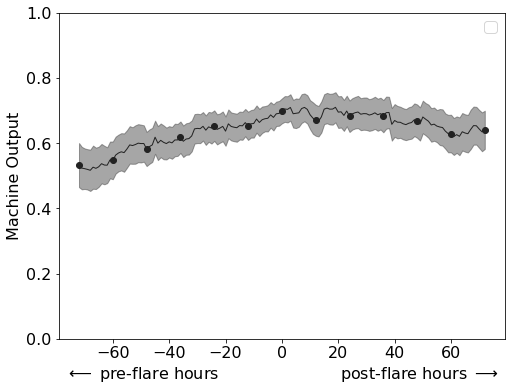

In [28]:
x_data = np.linspace(-72, 72, num=145, endpoint=True)
y_data = np.array(avgPredDict)
std = np.array(stdPredDict)

_, ax = plt.subplots()
markers_on = 12
ax.plot(x_data, y_data, '-o', lw = 1, color = '#222222', alpha = 1, markevery=markers_on)
ax.fill_between(x_data, y_data + std, y_data - std, color = '#222222', alpha = 0.4)
ax.set_ylim(0.0, 1)
ax.set_xlabel('$\longleftarrow$ pre-flare hours' + '\t \t \t' + 'post-flare hours $\longrightarrow$')
ax.set_ylabel('Machine Output')
ax.legend(loc = 'best')

#### `Magnetic flux with machine prediction =====>`

In [25]:
model = load_model('inception_with_generator/model_3.h5')

flr_files = glob.glob('../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/*_1.dat')
nflr_files = glob.glob('../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/*_0.dat')

flr_pred = []
nflr_pred = []

flr_mag = []
nflr_mag = []

for fl in flr_files:
    img = np.load(fl)
    img = img.reshape(1, 256, 256, 1)
    pred = model.predict(img)
    flr_pred.append(float(pred[0]))
    flr_mag.append(np.sum(np.abs(np.load(rescaled_path_to_original_path(fl)))))

for fl in nflr_files:
    img = np.load(fl)
    img = img.reshape(1, 256, 256, 1)
    pred = model.predict(img)
    nflr_pred.append(float(pred[0]))
    nflr_mag.append(np.sum(np.abs( np.load(rescaled_path_to_original_path(fl)) )))



flr_dict = {'pred' : flr_pred, 'mag' : flr_mag}
nflr_dict = {'pred' : nflr_pred, 'mag' : nflr_mag}

flr_data = pd.DataFrame(flr_dict)
nflr_data = pd.DataFrame(nflr_dict)

fl_hist_mag = []
nfl_hist_mag = []

nfl_std = []
fl_std = []

for i in range(5):
    low = nflr_data['pred'] > i*0.2
    high = nflr_data['pred'] <= i*0.2 + 0.2
    dt = nflr_data.loc[low & high]
    nfl_hist_mag.append(np.mean(dt['mag']))
    nfl_std.append(np.std(dt['mag'])/np.sqrt(len(dt['mag'])))
    
    
    low = flr_data['pred'] > i*0.2
    high = flr_data['pred'] <= i*0.2 + 0.2
    dt = flr_data.loc[low & high]
    fl_hist_mag.append(np.mean(dt['mag']))
    fl_std.append(np.std(dt['mag'])/np.sqrt(len(dt['mag'])))

In [26]:
np.save('fl_hist_mag.npy', fl_hist_mag)
np.save('nfl_hist_mag.npy', nfl_hist_mag)
np.save('fl_std.npy', fl_std)
np.save('nfl_std.npy', nfl_std)

In [29]:
fl_hist_mag = np.load('fl_hist_mag.npy')
nfl_hist_mag = np.load('nfl_hist_mag.npy')
fl_std = np.load('fl_std.npy')
nfl_std = np.load('nfl_std.npy')

In [30]:
print(nfl_hist_mag)

[ 4266743.20148541  7240389.96177832 11829555.90595903 18164339.46986061
 31527182.87490878]


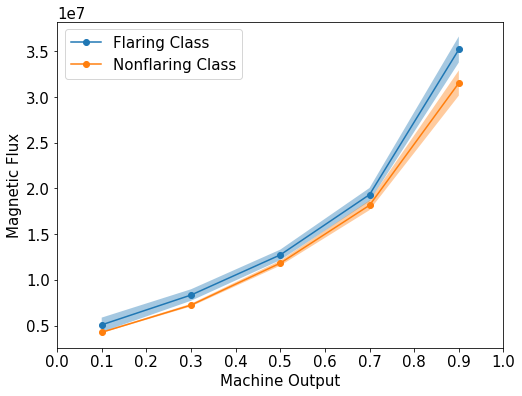

In [31]:
matplotlib.rc('font', size = 15)

_, ax = plt.subplots()
bins = [(0.2*i + 0.1) for i in range(5)]
ax.plot(bins, fl_hist_mag, '-o', label = 'Flaring Class',)
ax.fill_between(bins, fl_hist_mag + 10*fl_std, fl_hist_mag - 10*fl_std, alpha = 0.4)
ax.plot(bins, nfl_hist_mag, '-o', label = 'Nonflaring Class')
ax.fill_between(bins, nfl_hist_mag + 10*nfl_std, nfl_hist_mag - 10*nfl_std, alpha = 0.4)
ax.set_xlim(0, 1.0)
ax.set_xticks(np.arange(0.0,1.1,0.1))
#ax.set_xticks(np.arange(-72, 84, 12))

ax.set_xlabel('Machine Output')
ax.set_ylabel('Magnetic Flux')
ax.legend(loc = 'best')

In [16]:
nflr_pred = np.load('nflr_pred.npy')
flr_pred = np.load('flr_pred.npy')

In [17]:
flare_hist, bins = np.histogram(flr_pred, bins=[0.1*j for j in range(11)])

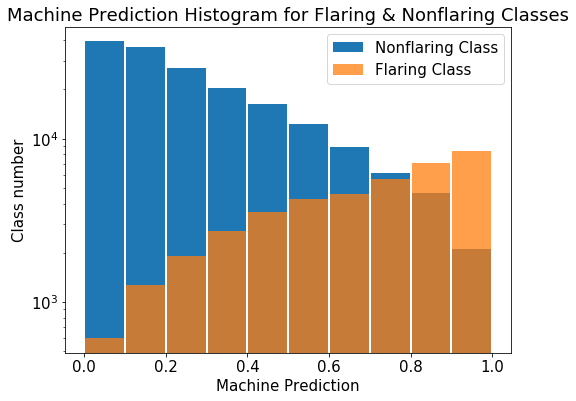

In [18]:
_, ax = plt.subplots()
ax.hist(nflr_pred, align='mid', alpha=1, bins=[0.1*j for j in range(11)], rwidth=0.95, label='Nonflaring Class')
ax.hist(flr_pred, align='mid', alpha=0.75, bins=[0.1*j for j in range(11)], rwidth=0.95, label='Flaring Class')
ax.set_yscale('log')
ax.set_ylabel('Class number')
ax.set_xlabel('Machine Prediction')
ax.set_title('Machine Prediction Histogram for Flaring & Nonflaring Classes')
ax.legend(loc='best')

    cross_val = np.load('inception_with_generator/rasha_cross_val_2.npy')
    print(cross_val)

In [40]:
all_files = glob.glob('../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/*flaring/*/*.dat')

active_region_counts = {}

for fl in all_files:
    img = np.load(fl)
    if (np.isnan(img).any()):
        os.unlink(fl)
    active = get_active_region(fl)
    active_region_counts[active] = active_region_counts.get(active, 0) + 1

In [43]:
np.save('active_region_counts.npy', active_region_counts)

In [10]:
active_region_counts = np.load('active_region_counts.npy')

In [20]:
rasha_train = np.load('rasha_train.npy')
rasha_validation = np.load('rasha_validation.npy')

In [21]:
FLARE_TEST = ['5956', '5974', '5982', '5983', '6015', '6026', '6052', '6063','6078', '6205', '6206', '6327', '6483', '6670', '6870', '6972', '7075', '7110', '7115', '7169']

NONFLARE_TEST = ['5935', '5944', '5961', '5963', '5970', '5976', '5990', '5991','5996', '6004', '6006', '6013', '6027', '6060', '6075', '6084','6093', '6099', '6100', '6104', '6115', '6124', '6136', '6140','6154', '6155', '6159', '6164', '6167', '6172', '6174', '6178','6192', '6223', '6224', '6230', '6242', '6246', '6247', '6258','6273', '6281', '6284', '6289', '6301', '6302', '6313', '6317','6319', '6320', '6324', '6326', '6351', '6359', '6361', '6375','6379', '6383', '6398', '6399', '6403', '6409', '6418', '6424','6437', '6454', '6464', '6498', '6500', '6505', '6507', '6510','6515', '6518', '6523', '6532', '6537', '6544', '6545', '6550','6556', '6558', '6566', '6576', '6594', '6599', '6613', '6615','6617', '6620', '6626', '6648', '6657', '6662', '6664', '6666','6683', '6692', '6693', '6699', '6703', '6711', '6715', '6716','6722', '6728', '6731', '6737', '6745', '6754', '6759', '6764','6769', '6774', '6780', '6789', '6794', '6798', '6803', '6804','6810', '6815', '6820', '6829', '6838', '6846', '6863', '6868','6869', '6870', '6892', '6910', '6920', '6922', '6930', '6939','6949', '6951', '6952', '6961', '6975', '6982', '6983', '6986','6988', '6994', '6999', '7016', '7022', '7030', '7034', '7045','7050', '7058', '7068', '7081', '7096', '7100', '7107', '7117','7120', '7122', '7123', '7127', '7131', '7144', '7147', '7148']    

In [22]:
data = {}
data['flare_train'] = np.unique(np.array([get_active_region(fl) for fl in rasha_train.item()['9'] if get_flag(fl) == 1 ]))
data['nonflare_train'] = np.unique(np.array([get_active_region(fl) for fl in rasha_train.item()['9'] if get_flag(fl) == 0]))
data['flare_validation'] = np.unique(np.array([get_active_region(fl) for fl in rasha_validation.item()['9'] if get_flag(fl) == 1 ]))
data['nonflare_validation'] = np.unique(np.array([get_active_region(fl) for fl in rasha_validation.item()['9'] if get_flag(fl) == 0]))
#data['flare_test'] = np.array(FLARE_TEST)
#data['nonflare_test'] = np.array(NONFLARE_TEST)

print(len(data['flare_train']))
print(len(data['nonflare_train']))
print(len(data['flare_validation']))
print(len(data['nonflare_validation']))
#print(len(data['flare_test']))
#print(len(data['nonflare_test']))

np.save('data.npy', data)

113
484
48
212


In [9]:
files = []
for ar in data['flare_validation']:
    arstr = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*.dat' %(ar)
    files.extend(glob.glob(arstr))
    
print(len(files))

10234


In [26]:
validation_regions = {}
for ky in rasha_validation.item().keys():
    validation_regions[ky] = np.unique(np.array([get_active_region(fl) for fl in rasha_validation.item()[ky]]))

In [28]:
np.save('train_regions.npy', train_regions)
np.save('validation_regions.npy', validation_regions)

In [47]:
rasha_test = ['5935', '5944', '5961', '5963', '5970', '5976', '5990', '5991',
       '5996', '6004', '6006', '6013', '6027', '6060', '6075', '6084',
       '6093', '6099', '6100', '6104', '6115', '6124', '6136', '6140',
       '6154', '6155', '6159', '6164', '6167', '6172', '6174', '6178',
       '6192', '6223', '6224', '6230', '6242', '6246', '6247', '6258',
       '6273', '6281', '6284', '6289', '6301', '6302', '6313', '6317',
       '6319', '6320', '6324', '6326', '6351', '6359', '6361', '6375',
       '6379', '6383', '6398', '6399', '6403', '6409', '6418', '6424',
       '6437', '6454', '6464', '6498', '6500', '6505', '6507', '6510',
       '6515', '6518', '6523', '6532', '6537', '6544', '6545', '6550',
       '6556', '6558', '6566', '6576', '6594', '6599', '6613', '6615',
       '6617', '6620', '6626', '6648', '6657', '6662', '6664', '6666',
       '6683', '6692', '6693', '6699', '6703', '6711', '6715', '6716',
       '6722', '6728', '6731', '6737', '6745', '6754', '6759', '6764',
       '6769', '6774', '6780', '6789', '6794', '6798', '6803', '6804',
       '6810', '6815', '6820', '6829', '6838', '6846', '6863', '6868',
       '6869', '6870', '6892', '6910', '6920', '6922', '6930', '6939',
       '6949', '6951', '6952', '6961', '6975', '6982', '6983', '6986',
       '6988', '6994', '6999', '7016', '7022', '7030', '7034', '7045',
       '7050', '7058', '7068', '7081', '7096', '7100', '7107', '7117',
       '7120', '7122', '7123', '7127', '7131', '7144', '7147', '7148',
       '7171', '7189', '7192', '7211', '7229', '7237', '7251', '7256',
       '7261', '7262', '7269', '7274', '7275', '7276', '7283', '7299',
       '7300', '7323', '7325', '7331', '7334', '7341', '7348']

In [65]:
nonmatch = []
for ar in rasha_test:
    if ar not in data['nonflare_test']:
        nonmatch.append(ar)

In [19]:
model = load_model('inception_with_generator/model_3.h5')

flr_files = glob.glob('../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/*_1.dat')
nflr_files = glob.glob('../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/*_0.dat')

flr_pred = []
nflr_pred = []

flr_mag = []
nflr_mag = []

flr_pth = []
nflr_pth = []

for fl in flr_files:
    img = np.load(fl)
    img = img.reshape(1, 256, 256, 1)
    pred = model.predict(img)
    flr_pred.append(float(pred[0]))
    flr_mag.append(np.sum(np.abs(np.load(rescaled_path_to_original_path(fl)))))
    flr_pth.append(fl)

for fl in nflr_files:
    img = np.load(fl)
    img = img.reshape(1, 256, 256, 1)
    pred = model.predict(img)
    nflr_pred.append(float(pred[0]))
    nflr_mag.append(np.sum(np.abs( np.load(rescaled_path_to_original_path(fl)) )))
    nflr_pth.append(fl)



flr_dict = {'pred' : flr_pred, 'mag' : flr_mag, 'pth' : flr_pth}
nflr_dict = {'pred' : nflr_pred, 'mag' : nflr_mag, 'pth' : nflr_pth}

flr_data = pd.DataFrame(flr_dict)
nflr_data = pd.DataFrame(nflr_dict)

fl_hist_mag = []
nfl_hist_mag = []

nfl_std = []
fl_std = []


file_data = {}
for i in range(5):
    file_data[i] = {}
    file_data[i]['max'] = []
    file_data[i]['min'] = []
    low = flr_data['pred'] > i*0.2
    high = flr_data['pred'] <= i*0.2 + 0.2
    dt = flr_data.loc[low & high]
    #print(dt)
    
    for _ in range(3):
        
        objmax = dt.loc[dt['mag'].idxmax()]
        file_data[i]["max"].append(objmax["pth"])
        
        objmin = dt.loc[dt['mag'].idxmin()]
        file_data[i]["min"].append(objmin["pth"])
        
        dt = dt.drop([dt['mag'].idxmax(), dt['mag'].idxmin()])

In [ ]:
file_data

In [ ]:
validation = trainingAndValidationFiles()
activeRegions = return_unique_active_regions(validation)

In [18]:
model = load_model('inception_with_generator/model_3.h5')
tn = {}
fp = {}

for rgn in activeRegions:
    rgnstr = '../shared/Data/HMI_LOS_SHARPS/valid_magnetograms/los/%s_*_0.dat' %(rgn)
    files = glob.glob(rgnstr)
    tn[rgn] = []
    fp[rgn] = []
    for fl in files:
        file_name = os.path.split(fl)[-1]
        start = file_name.index('_')
        end = file_name.index('_', start+1)
        timestamp = file_name[start+1:end]
        
        img = np.load(fl)
        img = img.reshape(1, 256, 256, 1)
        pred = float(model.predict(img))
        if (pred < 0.5):
            tn[rgn].append(timestamp)
        else:
            fp[rgn].append(timestamp)

In [19]:
np.save('tn_dict.npy', tn)
np.save('fp_dict.npy', fp)